In [1]:
from modulos import ann, eda, ml_func
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

2025-08-13 19:01:29.775180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755126089.787541 1992350 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755126089.791149 1992350 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755126089.801697 1992350 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755126089.801710 1992350 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755126089.801711 1992350 computation_placer.cc:177] computation placer alr

In [2]:
df = eda.data_processing('Cotas extraidas', '1903-01-01', '2025-07-31', ['dados_diarios_estacao_14990000.csv'])
df

,14990000
Data,
1903-01-01,1914.0
1903-01-02,1921.0
1903-01-03,1924.0
1903-01-04,1926.0
1903-01-05,1929.0
...,...
2025-07-27,2861.0
2025-07-28,2857.0
2025-07-29,2855.0


In [3]:
df_mensal = df.resample('MS').mean()
df_mensal

,14990000
Data,
1903-01-01,1998.322581
1903-02-01,2139.678571
1903-03-01,2245.161290
1903-04-01,2437.966667
1903-05-01,2612.838710
...,...
2025-03-01,2508.580645
2025-04-01,2676.766667
2025-05-01,2816.096774


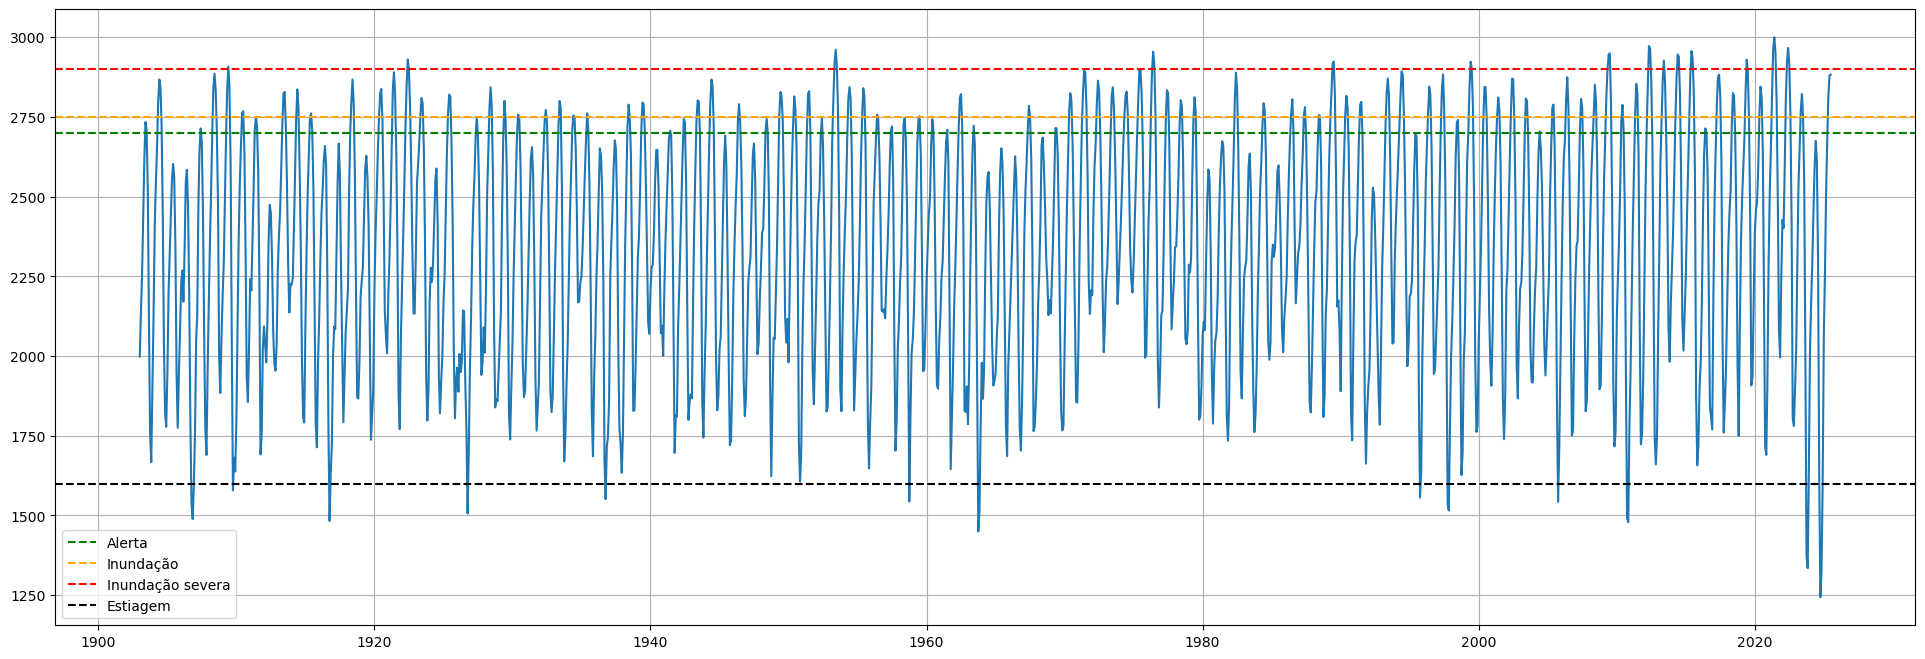

In [4]:
plt.figure(figsize=(24, 8))
plt.plot(df_mensal['14990000'])
plt.axhline(y=2700, color='green', linestyle='--', label='Alerta')
plt.axhline(y=2750, color='orange', linestyle='--', label='Inundação')
plt.axhline(y=2900, color='red', linestyle='--', label='Inundação severa')
plt.axhline(y=1600, color='black', linestyle='--', label='Estiagem')
plt.legend()
plt.grid()
plt.show()

In [5]:
prec = pd.read_csv('Precipitação/manaus_prec.csv', sep=';')
prec.index = pd.to_datetime(prec['Data'])
prec.drop(columns=['Data'], inplace=True)
prec

,value
Data,
1985-01-01,0.000000
1985-01-02,1.625000
1985-01-03,0.000000
1985-01-04,0.000000
1985-01-05,0.000000
...,...
2020-12-27,4.781250
2020-12-28,12.757810
2020-12-29,44.960940


In [6]:
prec_mensal = prec.resample('MS').mean()
prec_mensal

,value
Data,
1985-01-01,1.381048
1985-02-01,1.274554
1985-03-01,1.401210
1985-04-01,2.743750
1985-05-01,14.677419
...,...
2020-08-01,5.302419
2020-09-01,2.881250
2020-10-01,3.250000


In [7]:
el_nino_mensal3 = pd.read_csv('El Nino - indices/nino3_index.txt',
                             sep=r'\s+',
                             comment='#',
                             names=['Data', 'El Nino 3'])

el_nino_mensal34 = pd.read_csv('El Nino - indices/nino34_index.txt',
                             sep=r'\s+',
                             comment='#',
                             names=['Data', 'El Nino 3.4'])

el_nino_mensal3['Data'] = pd.to_datetime(el_nino_mensal3['Data'])
el_nino_mensal3.index = el_nino_mensal3['Data']
el_nino_mensal3.drop(columns=['Data'], inplace=True)

el_nino_mensal34['Data'] = pd.to_datetime(el_nino_mensal34['Data'])
el_nino_mensal34.index = el_nino_mensal34['Data']
el_nino_mensal34.drop(columns=['Data'], inplace=True)

df = df_mensal['1985-01-01':'2020-12-01'].copy()
df['El Nino 3.4'] = el_nino_mensal34['El Nino 3.4']['1985-01-01':'2020-12-01']
df['El Nino 3'] = el_nino_mensal3['El Nino 3']['1985-01-01':'2020-12-01']
df['Prec'] = prec_mensal['value']
df

,14990000,El Nino 3.4,El Nino 3,Prec
Data,,,,
1985-01-01,2297.870968,-2.679568,-2.992533,1.381048
1985-02-01,2349.357143,-1.937945,-1.421772,1.274554
1985-03-01,2310.838710,-0.971542,0.363471,1.401210
1985-04-01,2343.300000,-0.206249,1.460344,2.743750
1985-05-01,2437.322581,0.036957,0.984154,14.677419
...,...,...,...,...
2020-08-01,2639.258065,-0.304183,-0.510499,5.302419
2020-09-01,2157.500000,-0.463650,-1.519910,2.881250
2020-10-01,1716.096774,-1.133208,-2.252104,3.250000


In [14]:
tgt = '14990000'

decomp = seasonal_decompose(df['14990000'], model='additive', period=12)
deseason = df[tgt] - decomp.seasonal

for c in df.columns[:len(df.columns)-1]:
    if c == tgt:
        continue

    best_lag = None
    d_best_lag = None
    min_corr = np.inf
    d_min_corr = np.inf

    for i in range(0, 10):
        corr = df[tgt].corr(df[c].shift(i), method='spearman')
        d_corr = deseason.corr(df[c].shift(i), method='spearman')

        if corr < min_corr:
            min_corr = corr
            best_lag = i
        
        if d_corr < d_min_corr:
            d_min_corr = d_corr
            d_best_lag = i
    
    print(f"Coluna: {c}")
    print(f"Melhor lag = {best_lag}; Correlação = {min_corr:.4f}")
    print(f"D Melhor lag = {d_best_lag}; Correlação = {d_min_corr:.4f}\n")

Coluna: El Nino 3.4
Melhor lag = 5; Correlação = -0.7009
D Melhor lag = 6; Correlação = -0.2631

Coluna: El Nino 3
Melhor lag = 6; Correlação = -0.8553
D Melhor lag = 6; Correlação = -0.1568



In [15]:
tgt = '14990000'

decomp = seasonal_decompose(df['14990000'], model='additive', period=12)
deseason = df[tgt] - decomp.seasonal

best_lag = None
d_best_lag = None
max_corr = -np.inf
d_max_corr = -np.inf

for i in range(0, 10):
    corr = df[tgt].corr(df['Prec'].shift(i), method='spearman')
    d_corr = deseason.corr(df['Prec'].shift(i), method='spearman')

    if corr > max_corr:
        max_corr = corr
        best_lag = i
        
    if d_corr > d_max_corr:
        d_max_corr = d_corr
        d_best_lag = i

print(f"Melhor lag = {best_lag}; Correlação = {max_corr:.4f}")
print(f"D Melhor lag = {d_best_lag}; Correlação = {d_max_corr:.4f}\n")

Melhor lag = 0; Correlação = 0.6398
D Melhor lag = 2; Correlação = 0.1704



### Teste ML 1

In [16]:
treino = df_mensal['1985-01-01':'2014-12-01']
teste = df_mensal['2015-01-01':]

janela = 3
steps = 1
X, y = ml_func.create_multi_step_dataset(df_mensal['14990000']['1985-01-01':].values, janela, steps)

x_train1 = X[:treino.shape[0]-janela]
y_train1 = y[:treino.shape[0]-janela]

x_test1 = X[treino.shape[0]-janela:]
y_test1 = y[treino.shape[0]-janela:]

x_scale1 = MinMaxScaler()
x_train1 = x_scale1.fit_transform(x_train1)
x_test1 = x_scale1.transform(x_test1)

y_scale1 = MinMaxScaler()
y_train1 = y_scale1.fit_transform(y_train1)

In [14]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
lstm = ann.build_model_lstm(30, janela, steps)

lstm.fit(x_train1, y_train1, epochs=250, callbacks=early_stop)

I0000 00:00:1755124251.726728 1757288 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/250


I0000 00:00:1755124253.173415 1758253 cuda_dnn.cc:529] Loaded cuDNN version 90300


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2692 - mean_absolute_error: 0.4688
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1429 - mean_absolute_error: 0.3311 
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0806 - mean_absolute_error: 0.2537 
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505 - mean_absolute_error: 0.1933 
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0510 - mean_absolute_error: 0.1837 
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0535 - mean_absolute_error: 0.1928 
Epoch 7/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - mean_absolute_error: 0.1883 
Epoch 8/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469 - mean_absolute_error: 0.1883 
Epoch 9/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - mean_absolute_error: 0.1817 
Epoch 10/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471 - mean_absolute_error: 0.1806 
Epoch 11/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s

In [19]:
pred1 = lstm.predict(x_test1)
pred1_inv = y_scale1.inverse_transform(pred1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


R² = 0.9213


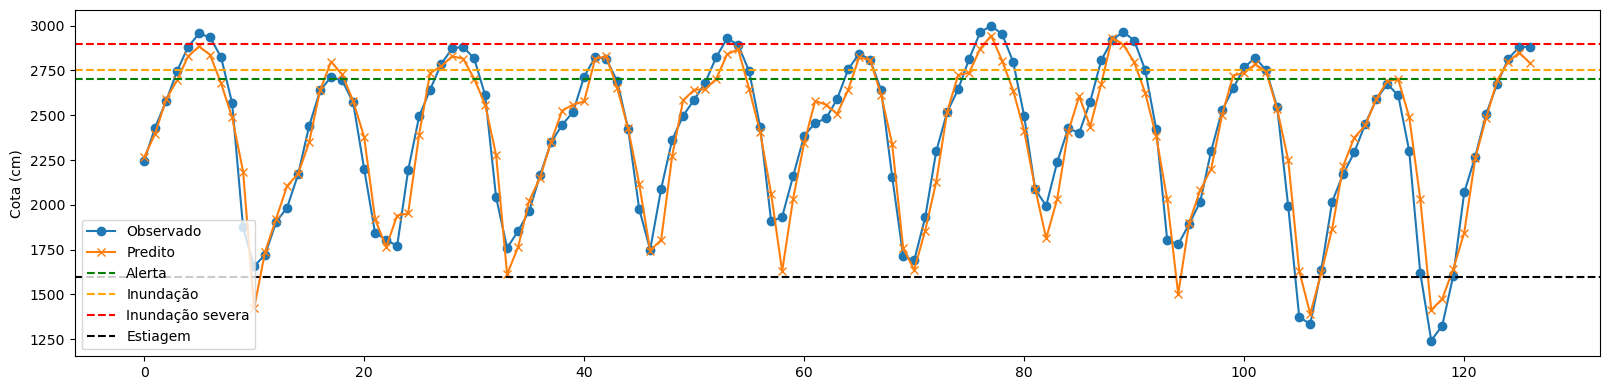

In [20]:
print(f"R² = {r2_score(y_test1, pred1_inv):.4f}")

plt.figure(figsize=(16, 4))
plt.plot(y_test1, marker='o', linestyle='-', label='Observado')
plt.plot(pred1_inv, marker='x', linestyle='-', label='Predito')
plt.axhline(y=2700, color='green', linestyle='--', label='Alerta')
plt.axhline(y=2750, color='orange', linestyle='--', label='Inundação')
plt.axhline(y=2900, color='red', linestyle='--', label='Inundação severa')
plt.axhline(y=1600, color='black', linestyle='--', label='Estiagem')
plt.legend(loc='lower left')
plt.tight_layout()
plt.ylabel('Cota (cm)')
plt.show()

### Teste ML 2

In [21]:
df_shifts = {
    '14990000': df['14990000'],
    'El Nino 3 - lag 6': df['El Nino 3'].shift(6),
    'El Nino 3.4 - lag 6': df['El Nino 3.4'].shift(6)
}

df_shifts = pd.DataFrame(df_shifts, index=df.index)
df_shifts

,14990000,El Nino 3 - lag 6,El Nino 3.4 - lag 6
Data,,,
1985-01-01,2297.870968,NaN,NaN
1985-02-01,2349.357143,NaN,NaN
1985-03-01,2310.838710,NaN,NaN
1985-04-01,2343.300000,NaN,NaN
1985-05-01,2437.322581,NaN,NaN
...,...,...,...
2020-08-01,2639.258065,-0.173588,-0.649515
2020-09-01,2157.500000,1.503927,0.415126
2020-10-01,1716.096774,2.804599,1.345910


In [23]:
treino = df_shifts['1985-01-01':'2014-12-01']
teste = df_shifts['2015-01-01':]

In [24]:
janela = 3
steps = 1

X_cota, y = ml_func.create_multi_step_dataset(df_shifts['14990000']['1985-01-01':].values, janela, steps)

X = pd.DataFrame(X_cota)
X['nino3'] = df_shifts['El Nino 3 - lag 6']['1985-04-01':].values
X['nino34'] = df_shifts['El Nino 3.4 - lag 6']['1985-04-01':].values

In [26]:
x_scale2 = MinMaxScaler()
y_scale2 = MinMaxScaler()

x_train2 = X.values[janela:treino.shape[0]-janela]
y_train2 = y[janela:treino.shape[0]-janela]

x_test2 = X.values[treino.shape[0]-janela:]
y_test2 = y[treino.shape[0]-janela:]

x_train2 = x_scale2.fit_transform(x_train2)
x_test2 = x_scale2.transform(x_test2)

y_train2 = y_scale2.fit_transform(y_train2)

In [27]:
lstm2 = ann.build_model_lstm(150, x_train2.shape[1], steps, 'tanh')

lstm2.fit(x_train2, y_train2, epochs=250, callbacks=early_stop)

Epoch 1/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3009 - mean_absolute_error: 0.4832  
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0725 - mean_absolute_error: 0.2129 
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633 - mean_absolute_error: 0.2136 
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0665 - mean_absolute_error: 0.2172 
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0631 - mean_absolute_error: 0.2120 
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0564 - mean_absolute_error: 0.2020 
Epoch 7/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0618 - mean_absolute_error: 0.2096 
Epoch 8/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 - mean_absolute_error: 0.2005 
Epoch 9/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0544 - mean_absolute_error: 0.1974 
Epoch 10/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519 - mean_absolute_error: 0.1949 
Epoch 11/250
12/12 ━━━━━━━━━

In [28]:
pred2 = lstm2.predict(x_test2)
pred2_inv = y_scale2.inverse_transform(pred2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


R² = 0.9264


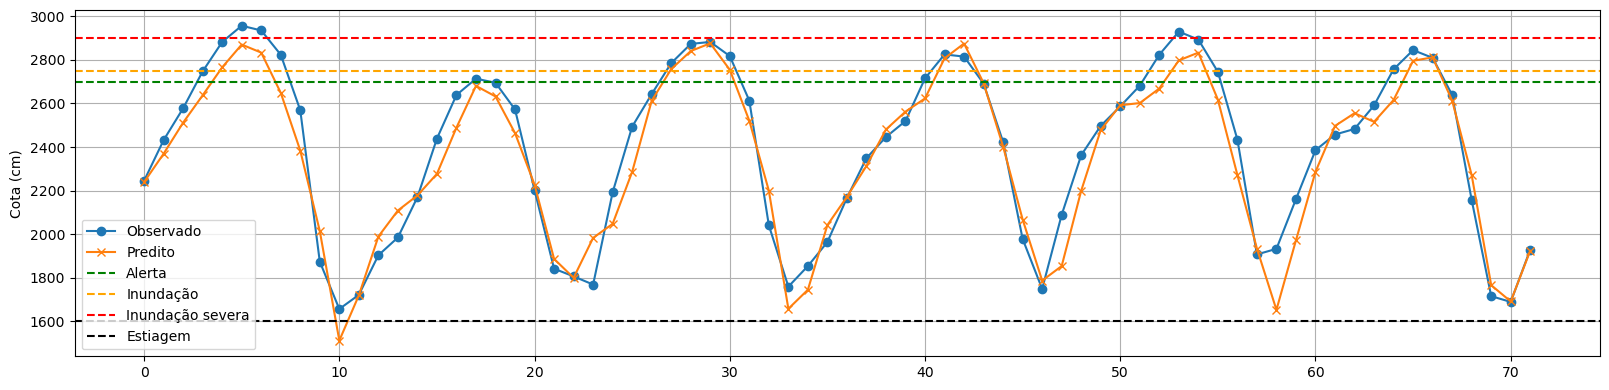

In [29]:
print(f"R² = {r2_score(y_test2, pred2_inv):.4f}")

plt.figure(figsize=(16, 4))
plt.plot(y_test2, marker='o', linestyle='-', label='Observado')
plt.plot(pred2_inv, marker='x', linestyle='-', label='Predito')
plt.axhline(y=2700, color='green', linestyle='--', label='Alerta')
plt.axhline(y=2750, color='orange', linestyle='--', label='Inundação')
plt.axhline(y=2900, color='red', linestyle='--', label='Inundação severa')
plt.axhline(y=1600, color='black', linestyle='--', label='Estiagem')
plt.legend(loc='lower left')
plt.tight_layout()
plt.ylabel('Cota (cm)')
plt.grid(True)
plt.show()

### Teste ML 3

In [38]:
X_a = X.drop(columns=['nino3', 'nino34'])
X_b = X.drop(columns=[0, 1, 2])

xa_scale = MinMaxScaler()
xb_scale = MinMaxScaler()
y_scale3 = MinMaxScaler()

X_train_a = X_a.values[janela:treino.shape[0]-janela]
X_train_b = X_b.values[janela:treino.shape[0]-janela]
y_train3 = y[janela:treino.shape[0]-janela:]

X_test_a = X_a.values[treino.shape[0]-janela:]
X_test_b = X_b.values[treino.shape[0]-janela:]
y_test3 = y[treino.shape[0]-janela:]

X_train_a = xa_scale.fit_transform(X_train_a)
X_test_a = xa_scale.transform(X_test_a)

X_train_b = xb_scale.fit_transform(X_train_b)
X_test_b = xb_scale.transform(X_test_b)

y_train3 = y_scale3.fit_transform(y_train3)

In [42]:
# # LSTM
# input_A = keras.layers.Input((janela, 1))
# lstm_layer = keras.layers.LSTM(30)(input_A)

# # MLP
# input_B = keras.layers.Input(shape=(X_train_b.shape[1],))
# dense1 = keras.layers.Dense(30)(input_B)
# dense2 = keras.layers.Dense(30)(dense1)

# # Concat
# concat = keras.layers.Concatenate()([lstm_layer, dense2])

# # Saída
# output = keras.layers.Dense(1)(concat)

# model = keras.Model(inputs=[input_A, input_B], outputs=[output])

# model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

lstm_mlp = ann.build_model_lstm_mlp(30, janela, (30, 30), X_train_b.shape[1])

lstm_mlp.fit((X_train_a, X_train_b), y_train3, epochs=250, callbacks=early_stop)

Epoch 1/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4314 - mean_absolute_error: 0.5959  
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1975 - mean_absolute_error: 0.3784 
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1118 - mean_absolute_error: 0.2891 
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1066 - mean_absolute_error: 0.2785 
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0935 - mean_absolute_error: 0.2581 
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0746 - mean_absolute_error: 0.2307 
Epoch 7/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0700 - mean_absolute_error: 0.2257 
Epoch 8/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0581 - mean_absolute_error: 0.2019 
Epoch 9/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0532 - mean_absolute_error: 0.1963 
Epoch 10/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0439 - mean_absolute_error: 0.1795 
Epoch 11/250
12/12 ━━━━━━━━━

In [45]:
pred3 = lstm_mlp.predict((X_test_a, X_test_b))
pred3_inv = y_scale3.inverse_transform(pred3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


R² = 0.9415


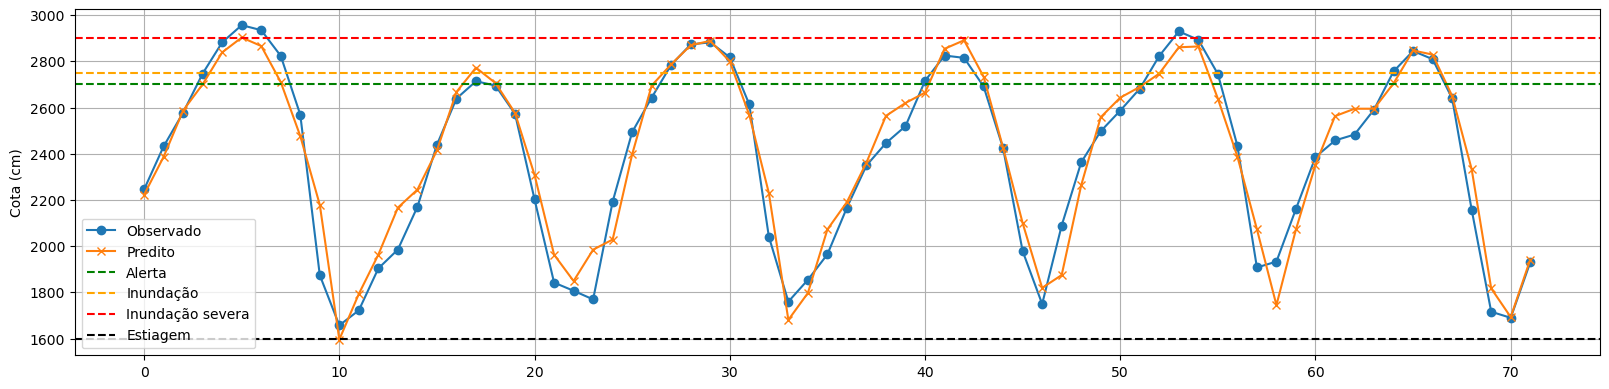

In [46]:
print(f"R² = {r2_score(y_test3, pred3_inv):.4f}")

plt.figure(figsize=(16, 4))
plt.plot(y_test3, marker='o', linestyle='-', label='Observado')
plt.plot(pred3_inv, marker='x', linestyle='-', label='Predito')
plt.axhline(y=2700, color='green', linestyle='--', label='Alerta')
plt.axhline(y=2750, color='orange', linestyle='--', label='Inundação')
plt.axhline(y=2900, color='red', linestyle='--', label='Inundação severa')
plt.axhline(y=1600, color='black', linestyle='--', label='Estiagem')
plt.legend(loc='lower left')
plt.tight_layout()
plt.ylabel('Cota (cm)')
plt.grid(True)
plt.show()

### Teste ML 4

In [8]:
df_shifts2 = {
    '14990000': df['14990000'],
    'El Nino 3 - lag 6': df['El Nino 3'].shift(6),
    'El Nino 3.4 - lag 6': df['El Nino 3.4'].shift(6),
    'Prec - lag 2': df['Prec'].shift(2)
}

df_shifts2 = pd.DataFrame(df_shifts2, index=df.index)
df_shifts2

,14990000,El Nino 3 - lag 6,El Nino 3.4 - lag 6,Prec - lag 2
Data,,,,
1985-01-01,2297.870968,NaN,NaN,NaN
1985-02-01,2349.357143,NaN,NaN,NaN
1985-03-01,2310.838710,NaN,NaN,1.381048
1985-04-01,2343.300000,NaN,NaN,1.274554
1985-05-01,2437.322581,NaN,NaN,1.401210
...,...,...,...,...
2020-08-01,2639.258065,-0.173588,-0.649515,10.068750
2020-09-01,2157.500000,1.503927,0.415126,6.211694
2020-10-01,1716.096774,2.804599,1.345910,5.302419


In [9]:
treino = df_shifts2['1985-01-01':'2014-12-01']
teste = df_shifts2['2015-01-01':]

In [11]:
janela = 3
steps = 1

X_cota, y = ml_func.create_multi_step_dataset(df_shifts2['14990000']['1985-01-01':].values, janela, steps)

X = pd.DataFrame(X_cota)
X['nino3'] = df_shifts2['El Nino 3 - lag 6']['1985-04-01':].values
X['nino34'] = df_shifts2['El Nino 3.4 - lag 6']['1985-04-01':].values
X['prec'] = df_shifts2['Prec - lag 2']['1985-04-01':].values
X

,0,1,2,nino3,nino34,prec
0,2297.870968,2349.357143,2310.838710,NaN,NaN,1.274554
1,2349.357143,2310.838710,2343.300000,NaN,NaN,1.401210
2,2310.838710,2343.300000,2437.322581,NaN,NaN,2.743750
3,2343.300000,2437.322581,2579.766667,-2.992533,-2.679568,14.677419
4,2437.322581,2579.766667,2597.870968,-1.421772,-1.937945,11.410417
...,...,...,...,...,...,...
424,2756.612903,2844.766667,2809.193548,-0.173588,-0.649515,10.068750
425,2844.766667,2809.193548,2639.258065,1.503927,0.415126,6.211694
426,2809.193548,2639.258065,2157.500000,2.804599,1.345910,5.302419
427,2639.258065,2157.500000,1716.096774,2.078183,0.896517,2.881250


In [12]:
X_a = X.drop(columns=['nino3', 'nino34', 'prec'])
X_b = X.drop(columns=[0, 1, 2])

xa_scale = MinMaxScaler()
xb_scale = MinMaxScaler()
y_scale4 = MinMaxScaler()

X_train_a = X_a.values[janela:treino.shape[0]-janela]
X_train_b = X_b.values[janela:treino.shape[0]-janela]
y_train4 = y[janela:treino.shape[0]-janela:]

X_test_a = X_a.values[treino.shape[0]-janela:]
X_test_b = X_b.values[treino.shape[0]-janela:]
y_test4 = y[treino.shape[0]-janela:]

X_train_a = xa_scale.fit_transform(X_train_a)
X_test_a = xa_scale.transform(X_test_a)

X_train_b = xb_scale.fit_transform(X_train_b)
X_test_b = xb_scale.transform(X_test_b)

y_train4 = y_scale4.fit_transform(y_train4)

In [19]:
lstm_mlp2 = ann.build_model_lstm_mlp(30, janela, (30, 30), X_train_b.shape[1])

lstm_mlp2.fit([X_train_a, X_train_b], y_train4, epochs=250, callbacks=early_stop)

Epoch 1/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3777 - mean_absolute_error: 0.5710  
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1722 - mean_absolute_error: 0.3575 
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0781 - mean_absolute_error: 0.2424 
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0561 - mean_absolute_error: 0.1971 
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0553 - mean_absolute_error: 0.1883 
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0428 - mean_absolute_error: 0.1691 
Epoch 7/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0382 - mean_absolute_error: 0.1629 
Epoch 8/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0312 - mean_absolute_error: 0.1482 
Epoch 9/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - mean_absolute_error: 0.1461 
Epoch 10/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0249 - mean_absolute_error: 0.1342 
Epoch 11/250
12/12 ━━━━━━━━━

In [20]:
pred4 = lstm_mlp2.predict([X_test_a, X_test_b])
pred4_inv = y_scale4.inverse_transform(pred4)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


R² = 0.9409


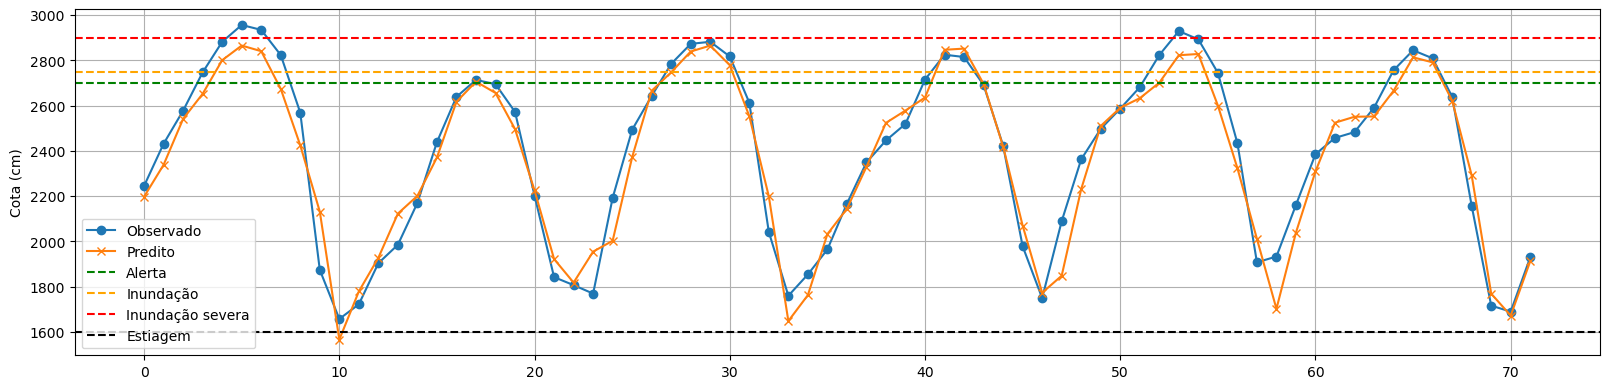

In [21]:
print(f"R² = {r2_score(y_test4, pred4_inv):.4f}")

plt.figure(figsize=(16, 4))
plt.plot(y_test4, marker='o', linestyle='-', label='Observado')
plt.plot(pred4_inv, marker='x', linestyle='-', label='Predito')
plt.axhline(y=2700, color='green', linestyle='--', label='Alerta')
plt.axhline(y=2750, color='orange', linestyle='--', label='Inundação')
plt.axhline(y=2900, color='red', linestyle='--', label='Inundação severa')
plt.axhline(y=1600, color='black', linestyle='--', label='Estiagem')
plt.legend(loc='lower left')
plt.tight_layout()
plt.ylabel('Cota (cm)')
plt.grid(True)
plt.show()